# File Descriptions and Data Field Information
## train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
## test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.
## sample_submission.csv
- A sample submission file in the correct format.
## stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.
## oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
## Transactions.csv
- Daily transactions per store
## holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
## Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Imports
First let us start by importing the relevant libraries that we need.

In [50]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
import pandas_datareader as web
import datetime as dt

# ML/DL imports
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Reading the Data
Let's start by reading our data. We will store them in dataframes. 

In [51]:
import os
path = '/Users/fab/Documents/pred/data/'
os.listdir(path)


['test.csv',
 'train.csv',
 'transactions.csv',
 'oil.csv',
 'holidays_events.csv',
 'sample_submission.csv',
 'stores.csv']

In [52]:
path = '/Users/fab/Documents/pred/data/'

train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
data_oil = pd.read_csv(path+'oil.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')
data_holi = pd.read_csv(path+'holidays_events.csv')
data_store =  pd.read_csv(path+'stores.csv')
data_trans = pd.read_csv(path+'transactions.csv')

# Exploratory Data Analysis (EDA)
## Exploring with Dataframe Analysis
Here we will analyze each dataframe to to understand the type of data we are working with. To do this, we create a simple function that we can call whenver we want to do basic dataframe analysis.

In [4]:
def basic_eda(df):
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print(df.head(5))
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print("-------------------------------Columns-----------------------------------")
    print(df.columns)
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print("----------------------------NULL values----------------------------------")
    print(df.isna().sum())
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)
    print("============================================================================ \n")

In [54]:
#Litle bit of exploration of data

print("=================================Train Data=================================")
basic_eda(train_data)
print("=================================Test data=================================")
basic_eda(test_data)
print("=================================Holidays events=================================")
basic_eda(data_holi)
print("=================================Transactions data=================================")
basic_eda(data_trans)
print("=================================Stores data=================================")
basic_eda(data_store)
print("=================================Oil data=================================")
basic_eda(data_oil)

=================================Train Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
-----------

Lucky for us, there seems not to be any missing values. This makes our lives easier.

## Exploring by plotting and analyzing graphs (using plotly)

### Sales Variation with store, family and clusters
To see the variation of sales per store, family and clusters in a subplot, we use plotly. 

In [55]:
# Creating one joined dataframe for visualization needs
df_visualization = train_data.merge(data_holi, on = 'date', how='left')
df_visualization = df_visualization.merge(data_oil, on = 'date', how='left')
df_visualization = df_visualization.merge(data_store, on = 'store_nbr', how='left')
df_visualization = df_visualization.merge(data_trans, on = ['date', 'store_nbr'], how='left')
df_visualization = df_visualization.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

df_visualization['date'] = pd.to_datetime(df_visualization['date'])
df_visualization['year'] = df_visualization['date'].dt.year
df_visualization['month'] = df_visualization['date'].dt.month
df_visualization['week'] = df_visualization['date'].dt.isocalendar().week
df_visualization['quarter'] = df_visualization['date'].dt.quarter
df_visualization['day_of_week'] = df_visualization['date'].dt.day_name()
df_visualization[:3]

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


In [56]:
# data -------------------------------------------------------------------------------
df_store_sales = df_visualization.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fam_sales = df_visualization.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_clus_sales = df_visualization.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

# chart color -------------------------------------------------------------------------------
df_fam_sales['color'] = '#008000'
df_fam_sales['color'][3:] = '#00FF00'
df_clus_sales['color'] = '#00FF00'

# chart -------------------------------------------------------------------------------
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fam_sales['sales'], y=df_fam_sales['family'], marker=dict(color= df_fam_sales['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_store_sales['sales'], labels=df_store_sales['store_type'], name='Store type',
                     marker=dict(colors=['#006400', '#008000','#228B22','#00FF00','#7CFC00','#00FF7F']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_clus_sales['cluster'], y=df_clus_sales['sales'], 
                     marker=dict(color= df_clus_sales['color']), name='Cluster'), 
                     row=2, col=1)

# styling -------------------------------------------------------------------------------
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_clus_sales.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

This allows us to get an initial understanding on how the sales varies depending on various variables.

### Sales variation by month and year
To see the variation of sales per month and year in one plot, we use plotly. 

In [57]:
# data 
df_2013 = df_visualization[df_visualization['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = df_visualization[df_visualization['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = df_visualization[df_visualization['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = df_visualization[df_visualization['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = df_visualization[df_visualization['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = pd.concat([df_2017, df_2017_no], ignore_index=True).rename(columns={'sales':'s17'})
# df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['#2EB62C', '#57C84D',
          '#83D475', '#ABE098',
          '#C5E8B7']

# X axis value 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2013['month'] =['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()

# create plotly figure
fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack',
    plot_bgcolor='#fff', 
    paper_bgcolor='#fff',
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):  
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='verdana', size=16,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='verdana ', size=16,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
        
    space = xd[0]
    for i in range(1, len(xd)):        
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='verdana ', size=16,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
            
fig.update_layout(
    annotations=annotations)
fig.show()

With this graph we can see that the sales are highest generally for the month of december and they also increase through the years. This can be due to many reasons such as Christmas gifts.

### Analyzing the relationship of Sales and Transactions amount with Oil price

In [58]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


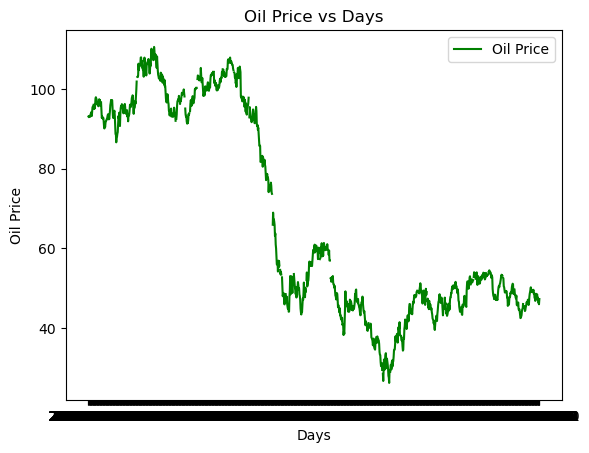

In [59]:
plt.plot(data_oil.set_index('date').dcoilwtico, color='green', label=f"Oil Price")
plt.title("Oil Price vs Days")
plt.xlabel("Days")
plt.ylabel("Oil Price")
plt.legend()
plt.show()

We group by the date and find the mean valus for sales and transactions for those grouped dates.

In [60]:
train_data_per_date = train_data.groupby('date').agg({'sales': 'mean'}).reset_index()
train_data_per_date['weekly_avg_sales'] = train_data_per_date['sales'].ewm(span=7, adjust=False).mean()

train_data_per_date.head()

,date,sales,weekly_avg_sales
0,2013-01-01,1.409438,1.409438
1,2013-01-02,278.390807,70.654780
2,2013-01-03,202.840197,103.701135
3,2013-01-04,198.911154,127.503640
4,2013-01-05,267.873244,162.596041


In [61]:
transactions_per_day = data_trans.groupby('date').agg({'transactions': 'mean'}).reset_index()
transactions_per_day['weekly_avg_transactions'] = transactions_per_day['transactions'].ewm(span=7, adjust=False).mean()

transactions_per_day.head()

,date,transactions,weekly_avg_transactions
0,2013-01-01,770.000000,770.000000
1,2013-01-02,2026.413043,1084.103261
2,2013-01-03,1706.608696,1239.729620
3,2013-01-04,1706.391304,1356.395041
4,2013-01-05,2034.195652,1525.845194


Let us compare sales and oil price

In [62]:
fig=make_subplots()

fig.add_trace(go.Scatter(x=train_data_per_date.date,y=train_data_per_date.sales,name="Sales"))
fig.add_trace(go.Scatter(x=train_data_per_date.date,y=train_data_per_date.weekly_avg_sales,name="Weekly Sales"))


fig.add_trace(go.Scatter(x=data_oil.date,y=data_oil.dcoilwtico,name="Oil Price"))

fig.update_layout(autosize=True,width=900,height=500,title_text="Variation of Sales and Oil Price Through Time")
fig.update_xaxes(title_text="Days")
fig.update_yaxes(title_text="Prices")
fig.show()

Let us compare transactions and oil price

In [63]:
fig=make_subplots()

fig.add_trace(go.Scatter(x=transactions_per_day.date,y=transactions_per_day.transactions,name="Transactions"))
fig.add_trace(go.Scatter(x=transactions_per_day.date,y=transactions_per_day.weekly_avg_transactions,name="Weekly Transactions"))

fig.add_trace(go.Scatter(x=data_oil.date,y=data_oil.dcoilwtico,name="Oil Price"))

fig.update_layout(autosize=True,width=900,height=500,title_text="Variation Transactions and Oil Price Through Time")
fig.update_xaxes(title_text="Days")
fig.update_yaxes(title_text="Prices")
fig.show()

We can also create a correlation matrix to see the correlation between the various variables.

In [64]:
data_oil['sales'] = train_data_per_date['sales']
data_oil['transactions'] = transactions_per_day['transactions']

# Use numeric_only=True to calculate correlation only on numeric columns
correlation_matrix = data_oil.corr(numeric_only=True)

print(correlation_matrix)


              dcoilwtico     sales  transactions
dcoilwtico      1.000000 -0.500805       0.04319
sales          -0.500805  1.000000       0.37651
transactions    0.043190  0.376510       1.00000


Analyzing the graphs and the correlation matrix, we get the understanding that there is no strong correlation between oil and transactions. There is slight inversion correlation between sales and oil price (representing loosely the economic status of a country)

# Training the model

In [65]:
path="./data/"
train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
data_oil = pd.read_csv(path+'oil.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')
data_holi = pd.read_csv(path+'holidays_events.csv')
data_store =  pd.read_csv(path+'stores.csv')
data_trans = pd.read_csv(path+'transactions.csv')

## Explore the training data

In [66]:
basic_eda(train_data)

-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
-------------------------------Describe----------------------------------
          stor

In [67]:
print(min(train_data['date']))
print(max(train_data['date']))

2013-01-01
2017-08-15


Let's find the numerical and categorical columns. This is important if you want to later standardize your numerical data or Encode your categorical data.

In [68]:
object_cols = [cname for cname in train_data.columns 
               if train_data[cname].dtype == "object" 
               and cname != "date"]

print("Categorical variables:")
object_cols 

Categorical variables:


['family']

In [69]:
num_cols = [cname for cname in train_data.columns 
            if train_data[cname].dtype in ['int64', 'float64']]

print("Numerical variables:")
num_cols 

Numerical variables:


['store_nbr', 'sales', 'onpromotion']

In [70]:
all_cols = num_cols + object_cols
print(all_cols)

['store_nbr', 'sales', 'onpromotion', 'family']


## Taking care of Categorical Features
Let us transform the categorical columns into numerical ones so that we can use them as features.

In [71]:
ordinal_encoder = OrdinalEncoder()
train_data[object_cols] = ordinal_encoder.fit_transform(train_data[object_cols])
train_data

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,0.0,0.000,0
1,2013-01-01,1,1.0,0.000,0
2,2013-01-01,1,2.0,0.000,0
3,2013-01-01,1,3.0,0.000,0
4,2013-01-01,1,4.0,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,28.0,438.133,0
3000884,2017-08-15,9,29.0,154.553,1
3000885,2017-08-15,9,30.0,2419.729,148


## Scaling of Numerical Features
We have to standardize our numerical data so that our leaning algorithm can perform better.

In [72]:
scaler = MinMaxScaler(feature_range=(0,1))

for col in num_cols:
    scaled_data = scaler.fit_transform(train_data[col].values.reshape(-1,1))
    train_data[col] = pd.Series(scaled_data.flatten())

train_data.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,0.0,0.0,0.0,0.0
1,2013-01-01,0.0,1.0,0.0,0.0
2,2013-01-01,0.0,2.0,0.0,0.0
3,2013-01-01,0.0,3.0,0.0,0.0
4,2013-01-01,0.0,4.0,0.0,0.0


## Grouping the Data
We need to group the data by the dates. This will make the prediction much easier.

In [31]:
train_data = train_data.groupby(['date']).agg({'sales':'mean', 'onpromotion':'mean'})
train_data.tail()

,sales,onpromotion
date,,
2017-08-11,0.003718,0.010738
2017-08-12,0.003566,0.006295
2017-08-13,0.003895,0.007030
2017-08-14,0.003424,0.006091
2017-08-15,0.003432,0.008031


In [73]:
TrainDataX = train_data.copy()
TrainDataY = train_data.sales.copy()

In [74]:
x_train, X_valid, y_train, y_valid = train_test_split(TrainDataX, TrainDataY, test_size=0.2, random_state=42)

In [75]:
x_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
2902383,2017-06-21,0.830189,0.0,0.000104,0.002699
1651514,2015-07-18,0.867925,29.0,0.002610,0.000000
1948349,2016-01-02,0.471698,29.0,0.000032,0.000000
2893871,2017-06-16,0.113208,2.0,0.000040,0.001350
2867501,2017-06-02,0.283019,32.0,0.000032,0.000000


In [76]:
y_train.head()

id
2902383    0.000104
1651514    0.002610
1948349    0.000032
2893871    0.000040
2867501    0.000032
Name: sales, dtype: float64

## Transforming the Input data into Time-Series data
We have to transform the training data into time-series accepte sequences to be then fed to our model. We have decided to use keras TimeseriesGenerator to create those sequences. You can also choose to seperate into sequences without using this function.

In [80]:
num_feature_input = len(x_train.columns)
num_feature_input

5

In [82]:
num_feature_input = len(x_train.columns)
history_input = 10

"""
Length: Number of past time steps to be included, 
batch_size: The amount of predicted days. Here we have 1 since we are trying to predict the next day using the last 30 days.
"""
generator = TimeseriesGenerator(x_train, y_train, length=history_input, batch_size = 1)

# Print the first sequence, you should see 30 past day (x) for 1 predicted day (y)
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))
    break

[[['2017-06-21' 0.830188679245283 0.0 0.00010423599028199846
   0.002699055330634278]
  ['2015-07-18' 0.8679245283018867 29.0 0.002610109287426734 0.0]
  ['2016-01-02' 0.4716981132075472 29.0 3.207261239446106e-05 0.0]
  ['2017-06-16' 0.11320754716981132 2.0 4.009076549307633e-05
   0.001349527665317139]
  ['2017-06-02' 0.2830188679245283 32.0 3.207261239446106e-05 0.0]
  ['2015-06-19' 0.1509433962264151 28.0 0.0028069709823039363
   0.021592442645074223]
  ['2017-08-11' 0.0 6.0 3.207261239446106e-05 0.0]
  ['2014-01-03' 0.11320754716981132 3.0 0.035640690523344856 0.0]
  ['2013-12-12' 0.018867924528301886 14.0 0.0 0.0]
  ['2014-06-19' 0.8867924528301887 27.0 0.0 0.0]]] => [0.]


In [83]:
print(len(generator))

2400700


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_simple_rnn_model(history_input, num_feature_input, rnn_units=32, output_units=1, output_activation='linear'):
    """
    Builds a simple RNN model for sequence prediction.

    Args:
        history_input (int): The number of time steps in the input sequences (e.g., look-back window).
        num_feature_input (int): The number of features for each time step in the input.
        rnn_units (int): The number of units in the SimpleRNN layer.
        output_units (int): The number of units in the output Dense layer (e.g., 1 for single value prediction).
        output_activation (str): The activation function for the output layer (e.g., 'linear' for regression).

    Returns:
        tensorflow.keras.models.Sequential: The Keras SimpleRNN model.
    """
    
    model = Sequential()
    
    # SimpleRNN layer
    # - rnn_units: Dimensionality of the output space (and hidden state).
    # - activation='tanh': A common activation for SimpleRNN layers. 'relu' can also be used.
    # - input_shape: Defines the shape of the input data (timesteps, features_per_timestep).
    # - return_sequences=False (default): Only the output of the last time step is returned,
    #   which is suitable for feeding into a Dense layer for a final prediction.
    #   If you were stacking RNN layers, the intermediate ones would need return_sequences=True.
    model.add(SimpleRNN(units=rnn_units, 
                        activation='tanh',  # 'tanh' is traditional, 'relu' is also an option
                        input_shape=(history_input, num_feature_input)))
    
    # Output Dense layer
    # - output_units: For a single value prediction (e.g., stock price).
    # - output_activation: For regression tasks where the output can be any real number.
    model.add(Dense(units=output_units, activation=output_activation))
    
    return model

if __name__ == '__main__':
    # --- Example Usage ---
    # You need to define these based on your dataset:
    HISTORY_LOOKBACK = 30  # Example: using the last 30 time steps
    NUM_FEATURES = 1       # Example: using 1 feature (e.g., just 'Close' price)

    # Create the model
    my_simple_rnn_model = build_simple_rnn_model(history_input=HISTORY_LOOKBACK,
                                                 num_feature_input=NUM_FEATURES,
                                                 rnn_units=32, # You can experiment with the number of RNN units
                                                 output_units=1,
                                                 output_activation='linear')
    
    # Print a summary of the model architecture
    my_simple_rnn_model.summary()
    
    # Before training, you would compile the model
    # Example compilation for a regression task:
    # my_simple_rnn_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Then you would train it with your data:
    # For example, if X_train.shape is (num_samples, HISTORY_LOOKBACK, NUM_FEATURES)
    # and y_train.shape is (num_samples, 1)
    # my_simple_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32)


In [84]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    
    # First LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = (history_input, num_feature_input))) 
    model.add(Dropout(0.2))
    
    # Second LSTM layer with Dropout regularisation; Set return_sequences to True to feed outputs to next layer
    model.add(LSTM(units = 50,  activation='relu', return_sequences = True))                                    
    model.add(Dropout(0.2))
    
    # Final LSTM layer with Dropout regularisation; Set return_sequences to False since now we will be predicting with the output layer
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [85]:
model = Multi_Step_LSTM_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 50)            11200     
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

2025-05-28 16:26:43.345172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-28 16:26:43.346279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-28 16:26:43.346858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Now we set our compiler and our optimatization mechanism. We will be using the Adam optimazation method since it is widely used and performs much better than regular gradient descent.

In [86]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

In [87]:
model.fit_generator(generator, steps_per_epoch=len(generator), epochs=10, verbose=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

## Save and Load model if needed
I have commented the two code blocks out. Uncomment and use if you need to:

a) save the model

In [43]:
# serialize model to JSON
model_json = model.to_json()
with open("model2_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2_1.h5")
print("Saved model to disk")

Saved model to disk


b) load the model

In [45]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('model2_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2_1.h5")
print("Loaded model from disk")

Loaded model from disk


2025-05-28 12:32:42.202181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-28 12:32:42.202923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-28 12:32:42.203328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [88]:
# num_feature_input = len(X_valid.columns)
# history_input = 30

# """
# length: Number of past time steps to be included, 
# batch_size: The amount of predicted days. Here we have 1 since we are trying to predict the next day using the last 30 days.
# """
# generator = TimeseriesGenerator(X_valid, y_valid, length=history_input, batch_size = 1)

# # Print the first sequence, you should see 30 past day (x) for 1 predicted day (y)
# for i in range(len(generator)):
#     x, y = generator[i]
#     print('%s => %s' % (x, y))
#     break

# y_predict = model.predict(generator)

# rmsle = np.sqrt(mean_squared_error(y_valid, y_predict))

In [46]:
from sklearn.metrics import mean_squared_error
import numpy as np

generator = TimeseriesGenerator(X_valid, y_valid, length=history_input, batch_size=1)

# Predict using the generator
y_pred = model.predict(generator).squeeze()

# Extract ground truth values from the generator
y_true = np.array([y for _, y in generator]).squeeze()

# Compute RMSLE (Root Mean Squared Log Error)
rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
print(f"RMSLE: {rmsle:.4f}")

2025-05-28 12:32:53.382438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-05-28 12:32:53.556594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-28 12:32:53.557082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

307/307 [==============================] - 1s 2ms/step
RMSLE: 0.0013


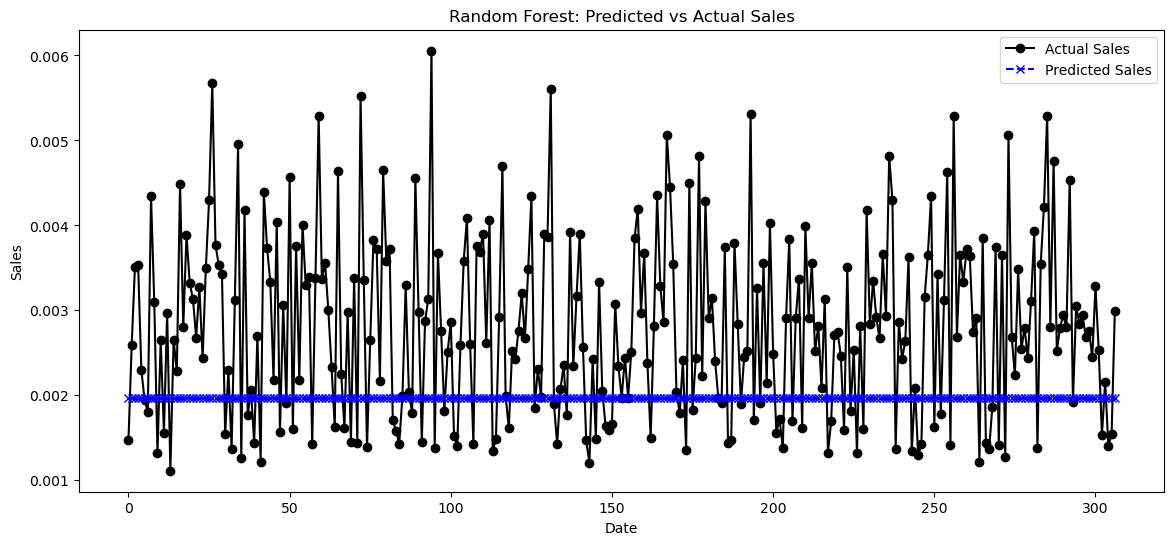

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you used a MinMaxScaler on y
y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).squeeze()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).squeeze()

# Create a DataFrame for visualization
df_rf = pd.DataFrame({'Actual Sales': y_true_inv, 'Predicted Sales': y_pred_inv})

# # Create a DataFrame for visualization
# df_rf = pd.DataFrame({'Actual Sales': y_true, 'Predicted Sales': y_pred})

# Sort the validation set by index for better visualization
df_rf = df_rf.sort_index()

# Plot actual vs predicted sales
plt.figure(figsize=(14, 6))
plt.plot(df_rf.index, df_rf['Actual Sales'], label="Actual Sales", marker='o', linestyle='solid', color='black')
plt.plot(df_rf.index, df_rf['Predicted Sales'], label="Predicted Sales", marker='x', linestyle='dashed', color='blue')

plt.title("Random Forest: Predicted vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
